In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import os
import glob
import itertools
import ipdb
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
from collections import OrderedDict
import pickle as pkl
from utils import u_plot as uplot, u_darrays as ua, u_met, u_interpolate as u_int, u_lists
import pandas as pd
from metpy.calc import kinematics

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [11]:
def get_CP4(cp_dir, out_dir, ancils_dir, vars, datestring, box,inter):
    

    #create empty dataset
    ds = xr.Dataset()
    # create empty
    
    keys = vars.keys()

    #loop through every var
    for v in keys:

        h = (vars[v])[1]
        pl = (vars[v])[0]
        derived = False
        if (v == 'shear') | (v == 'u_mid') | (v == 'u_srfc'):
            derived = v
            v = 'u_pl'

        filepath = cp_dir+os.sep+str(v)+os.sep+'*'+str(d['time.year'].values)+str(d['time.month'].values).zfill(2)+'*.nc'

        arr = xr.open_mfdataset(filepath, autoclose=True)

        dar = arr[v].sel(longitude=slice(box[0],box[1]), latitude=slice(box[2],box[3]))
        pdt = pd.to_datetime(datestring.values)
        pdt = pdt.replace(hour=h)
        dar = dar.sel(time=pdt, method='nearest')

        if int(dar['time.hour'])!=h:
            print('Wrong hour')
            return

        if 'pressure' in dar.coords:
            dar.values[dar.values==0] = np.nan # potential missing value maskout
            if len(pl) > 1:
                shear = dar.sel(pressure=pl[0]).values - dar.sel(pressure=pl[1]).values
                dar = dar.sum(dim='pressure').squeeze()
                dar.values = shear
                if derived:
                    v = derived

            else:
                dar = dar.sel(pressure=pl[0]).squeeze()
            if derived:
                v = derived

        # regrid to common grid (unstagger wind, bring to landsea mask grid)
        regrid = u_int.interpolate_data(dar.values, inter[0], inter[1], inter[2])
        #regrid = griddata_lin(dar.values, dar.longitude, dar.latitude, ls_arr.rlon, ls_arr.rlat)
        da = xr.DataArray(regrid,
                          coords={'time': dar.time, 'latitude': ls_arr.rlat.values,
                                  'longitude': ls_arr.rlon.values, },
                          dims=['latitude', 'longitude'])


        da.attrs = dar.attrs
        da.values[pos[0], pos[1]] = np.nan  # mask sea
        
        if (v == 'lsRain') | (v == 'totRain'):
            da.values = da.values*3600  # rain to mm/h
            da.attrs['units'] = 'mm h-1'

        ds[v] = da
        
    return ds

        #print('Saved ', v)


### Inputs CP25

data_path = cnst.network_data + 'data/CP4/CLOVER/CP4hist'  # CP4 data directory
ancils_path = cnst.network_data + 'data/CP4/ANCILS' # directory with seamask file inside
out_path = cnst.CLOVER_SAVES  # out directory to save MCS files

years = np.array(np.arange(1998,2007), dtype=str)
months = np.array([ '03', '04', '05', '09', '10', '11'])
days = np.array(np.arange(1,32), dtype=str)

box = [-15,15,3,16]

#load seamask
landsea_path = glob.glob(ancils_path+os.sep+'landseamask*.nc')[0]
landsea = xr.open_dataset(landsea_path, decode_times=False)
ls = landsea['lsm']

ls.rlon.values = ls.rlon.values-360
ls_arr = ls.sel(rlon=slice(box[0], box[1]), rlat=slice(box[2], box[3]))
pos = np.where(ls_arr[0, 0, :, :] == 0)

new_lons, new_lats = np.meshgrid(ls_arr.rlon.values, ls_arr.rlat.values)



#vars = u_lists.dir_names(data_path, dir_only=True)
vars = OrderedDict()   # dictionary which contains info on pressure level and hour extraction for wanted variables
vars['lw_out_PBLtop'] = ([], 18)
vars['lsRain'] =  ([], 18)   # pressure levels, hour # totRain for CP25, lsRain for CP
vars['shear'] = ([650, 925], 12) # should use 925 later
vars['u_mid'] = ([650], 12)
vars['u_srfc'] = ([925], 12)
vars['q_pl'] = ([925], 12)  # 925, 650 available

ds= xr.open_mfdataset(data_path+os.sep+'lw_out_PBLtop'+os.sep+'*200508*.nc', autoclose=True)
ds = ds.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3]))
ds = ds['lw_out_PBLtop'][ds['time.hour']==18]
time = ds.time

lons, lats = np.meshgrid(ds.longitude.values, ds.latitude.values)
inds, weights, shape = u_int.interpolation_weights(lons, lats, new_lons, new_lats)


ds_out = None

for d in time:
    out_ds = get_CP4(data_path, out_path, ancils_path, vars, d, box, (inds,weights,shape))

    if ds_out is None:
        ds_out = out_ds
    else:
    
        ds_out = xr.concat([ds_out, out_ds], dim='time')

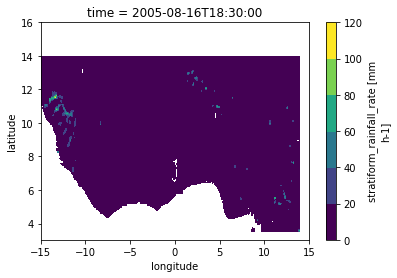

In [16]:
ds_out['lsRain'][15,:,:].plot.contourf()

In [6]:
data_path = cnst.network_data + 'data/CP4/CLOVER/CP4hist'

In [12]:
ds_out['lw_out_PBLtop'].shape

(321, 741)

In [22]:
def dir_names(data_path):
    dir_basename = []
    for d in glob.glob(data_path + '/*'):
        dir_basename.append(os.path.basename(d))
    return dir_basename

In [23]:
dirs = dir_names(data_path)

In [25]:
dirs

['lsRain', 'q_pl', 'u_pl', 'v_pl', 'lw_out_PBLtop', 't_pl', 't2', 'omega_pl']